In [3]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

rng = np.random.default_rng(42)

# Example non-uniform number of individuals per type
num_individuals_per_type = [36000, 24000, 8000, 12000, 10000, 1600, 3600, 800, 1600]
num_types = len(num_individuals_per_type)

# Initialize positions randomly
def initialize_positions_randomly(num_individuals_per_type, x_max, y_max, z_max):
    positions = []
    for num_individuals in num_individuals_per_type:
        for _ in range(num_individuals):
            position = [rng.integers(0, x_max), rng.integers(0, y_max), rng.integers(0, z_max)]
            positions.append(position)
    return np.array(positions, dtype='float64')

# Calculate forces based on the networkx graph within range r
def calculate_forces_complex(positions, graph, num_individuals_per_type, rs, alpha=1.0, sigma=1.0):
    forces = np.zeros_like(positions)
    
    # Precompute the start index for each type
    start_index = np.zeros(num_types, dtype=int)
    start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
    
    # Lennard-Jones force strength function
    def lennard_jones_force(distance, epsilon):
        force_magnitude = 48 * epsilon * ((sigma / distance)**13 - 0.5 * (sigma / distance)**7)
        return force_magnitude
    
    # Morse potential force strength function
    def morse_force(distance, epsilon):
        exp_term = np.exp(-alpha * (distance - sigma))
        force_magnitude = 2 * alpha * epsilon * exp_term * (1 - exp_term)
        return force_magnitude
    
    # Loop over each type
    for type_i in range(num_types):
        num_i = num_individuals_per_type[type_i]
        nghs = graph.neighbors(type_i)
        node = graph[type_i]
        r = rs[type_i] * 20
        
        # Loop over each individual in type_i
        for j in range(start_index[type_i], start_index[type_i] + num_i):
            pos_j = positions[j]
            
            # Loop over neighboring types
            for type_j in nghs:
                weight = node[type_j]['weight']
                num_j = num_individuals_per_type[type_j]
                
                # Determine interaction type based on weight
                if weight < 0:
                    interaction = 'repulsion'
                    epsilon = -weight  # Strength of repulsion
                else:
                    interaction = 'attraction'
                    epsilon = weight  # Strength of attraction
                
                # Loop over individuals in type_j
                for k in range(start_index[type_j], start_index[type_j] + num_j):
                    if j == k:
                        continue  # Avoid self-interaction
                    
                    pos_k = positions[k]
                    distance_vector = pos_k - pos_j
                    distance = np.linalg.norm(distance_vector)
                    
                    if distance <= r:
                        if interaction == 'repulsion':
                            force_magnitude = lennard_jones_force(distance, epsilon)
                        else:
                            force_magnitude = morse_force(distance, epsilon)

                            force_vector = force_magnitude * (distance_vector / distance) if distance != 0 else 0

                            forces[j] += force_vector
                            forces[k] -= force_vector
    
    return forces

# Calculate forces based on the networkx graph within range r
def calculate_forces_simple(positions, graph, num_individuals_per_type, rs):
    forces = np.zeros_like(positions)
    
    # Precompute the start index for each type
    start_index = np.zeros(num_types, dtype=int)
    start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
    
    g = 50
    alpha_base = 10
    
    # Yukawa force function
    def yukawa_force(distance, weight, alpha):
        force_magnitude = (g**2 * (1 + alpha * distance) / distance**2) * np.exp(-alpha * distance) * weight
        return force_magnitude
    
    # Loop over each type
    for type_i in range(num_types):
        num_i = num_individuals_per_type[type_i]
        nghs = graph.neighbors(type_i)
        node = graph[type_i]
        alph = alpha_base / rs[type_i]
        
        # Loop over each individual in type_i
        for j in range(start_index[type_i], start_index[type_i] + num_i):
            pos_j = positions[j]
            
            # Loop over neighboring types
            for type_j in nghs:
                weight = node[type_j]['weight']
                num_j = num_individuals_per_type[type_j]
                
                # Loop over individuals in type_j
                for k in range(start_index[type_j], start_index[type_j] + num_j):
                    if j == k:
                        continue  # Avoid self-interaction
                    
                    pos_k = positions[k]
                    distance_vector = pos_k - pos_j
                    distance = np.linalg.norm(distance_vector)
                    
                    #if distance <= max(r_i, r_j):  # Use the maximum of the two ranges
                    force_magnitude = yukawa_force(distance, weight, alph)#(weight / (distance ** 2))
                    force_vector = force_magnitude * (distance_vector / distance) if distance != 0 else 0
                
                    forces[j] += force_vector
                    forces[k] -= force_vector
    
    return forces

In [2]:
# Constants
x_max = 200  # Define the bounds of the 3D space
y_max = 200
z_max = 15
damping_factor = 10000000000000000  # Damping factor to stabilize the simulation
rs = [1, 1, 3, 3, 3, 4, 5, 6, 6]
iterations = 100

#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 3}, {"weight": 0.6148356427539814, "source": 0, "target": 4}, {"weight": 0.7306576990838498, "source": 1, "target": 2}, {"weight": 0.9003900420385831, "source": 1, "target": 5}, {"weight": -0.638579754693958, "source": 1, "target": 7}, {"weight": -0.27796656418881527, "source": 2, "target": 7}, {"weight": 0.46123412849139406, "source": 3, "target": 4}, {"weight": 0.6068144174853789, "source": 5, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 2}, {"weight": 0.6148356427539814, "source": 0, "target": 8}, {"weight": 0.7306576990838498, "source": 2, "target": 4}, {"weight": 0.9003900420385831, "source": 2, "target": 8}, {"weight": -0.638579754693958, "source": 3, "target": 6}, {"weight": -0.27796656418881527, "source": 3, "target": 8}, {"weight": 0.46123412849139406, "source": 4, "target": 5}, {"weight": 0.6068144174853789, "source": 7, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 1, "target": 4}, {"weight": 0.6148356427539814, "source": 1, "target": 5}, {"weight": 0.7306576990838498, "source": 1, "target": 6}, {"weight": 0.9003900420385831, "source": 2, "target": 5}, {"weight": -0.638579754693958, "source": 2, "target": 6}, {"weight": -0.27796656418881527, "source": 2, "target": 8}, {"weight": 0.46123412849139406, "source": 3, "target": 5}, {"weight": 0.6068144174853789, "source": 4, "target": 5}, {"weight": 0.5112680070896285, "source": 4, "target": 6}, {"weight": 0.42525572507758125, "source": 4, "target": 7}, {"weight": 0.4601658168250095, "source": 4, "target": 8}, {"weight": 0.4943223393958548, "source": 5, "target": 6}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 1}, {"weight": 0.6148356427539814, "source": 0, "target": 3}, {"weight": 0.7306576990838498, "source": 0, "target": 5}, {"weight": 0.9003900420385831, "source": 0, "target": 8}, {"weight": -0.638579754693958, "source": 1, "target": 3}, {"weight": -0.27796656418881527, "source": 1, "target": 5}, {"weight": 0.46123412849139406, "source": 1, "target": 6}, {"weight": 0.6068144174853789, "source": 3, "target": 7}, {"weight": 0.5112680070896285, "source": 3, "target": 8}, {"weight": 0.42525572507758125, "source": 4, "target": 5}, {"weight": 0.4601658168250095, "source": 4, "target": 6}, {"weight": 0.4943223393958548, "source": 4, "target": 7}, {"weight": -0.14671525430854027, "source": 4, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 1}, {"weight": 0.6148356427539814, "source": 0, "target": 3}, {"weight": 0.7306576990838498, "source": 0, "target": 4}, {"weight": 0.9003900420385831, "source": 0, "target": 6}, {"weight": -0.638579754693958, "source": 0, "target": 7}, {"weight": -0.27796656418881527, "source": 1, "target": 3}, {"weight": 0.46123412849139406, "source": 1, "target": 4}, {"weight": 0.6068144174853789, "source": 1, "target": 6}, {"weight": 0.5112680070896285, "source": 1, "target": 7}, {"weight": 0.42525572507758125, "source": 1, "target": 8}, {"weight": 0.4601658168250095, "source": 2, "target": 5}, {"weight": 0.4943223393958548, "source": 2, "target": 6}, {"weight": -0.14671525430854027, "source": 2, "target": 8}, {"weight": -0.4038872117981791, "source": 3, "target": 4}, {"weight": 0.5176903249517476, "source": 3, "target": 6}, {"weight": 0.7534244447856359, "source": 3, "target": 7}, {"weight": 0.5244768288592718, "source": 4, "target": 7}, {"weight": 0.7363358287149884, "source": 4, "target": 8}, {"weight": 0.631262017598583, "source": 5, "target": 6}, {"weight": 0.13566419265027413, "source": 5, "target": 8}, {"weight": 0.7444351489453024, "source": 6, "target": 7}, {"weight": -0.4320948133020824, "source": 7, "target": 8}]}'
#co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 1}, {"weight": 0.6148356427539814, "source": 0, "target": 3}, {"weight": 0.7306576990838498, "source": 0, "target": 4}, {"weight": 0.9003900420385831, "source": 0, "target": 6}, {"weight": -0.638579754693958, "source": 0, "target": 7}, {"weight": -0.27796656418881527, "source": 0, "target": 8}, {"weight": 0.46123412849139406, "source": 1, "target": 2}, {"weight": 0.6068144174853789, "source": 1, "target": 4}, {"weight": 0.5112680070896285, "source": 1, "target": 5}, {"weight": 0.42525572507758125, "source": 1, "target": 6}, {"weight": 0.4601658168250095, "source": 1, "target": 7}, {"weight": 0.4943223393958548, "source": 2, "target": 4}, {"weight": -0.14671525430854027, "source": 2, "target": 5}, {"weight": -0.4038872117981791, "source": 3, "target": 4}, {"weight": 0.5176903249517476, "source": 3, "target": 5}, {"weight": 0.7534244447856359, "source": 3, "target": 6}, {"weight": 0.5244768288592718, "source": 3, "target": 8}, {"weight": 0.7363358287149884, "source": 4, "target": 7}, {"weight": 0.631262017598583, "source": 4, "target": 8}, {"weight": 0.13566419265027413, "source": 5, "target": 7}, {"weight": 0.7444351489453024, "source": 5, "target": 8}, {"weight": -0.4320948133020824, "source": 6, "target": 8}, {"weight": -0.581091373256546, "source": 7, "target": 8}]}'
co_occ_network = '{"directed": false, "multigraph": false, "graph": {}, "nodes": [{"id": 0}, {"id": 1}, {"id": 2}, {"id": 3}, {"id": 4}, {"id": 5}, {"id": 6}, {"id": 7}, {"id": 8}], "links": [{"weight": 0.5826312884833548, "source": 0, "target": 5}, {"weight": 0.6148356427539814, "source": 0, "target": 8}, {"weight": 0.7306576990838498, "source": 1, "target": 3}, {"weight": 0.9003900420385831, "source": 1, "target": 4}, {"weight": -0.638579754693958, "source": 1, "target": 6}, {"weight": -0.27796656418881527, "source": 2, "target": 4}, {"weight": 0.46123412849139406, "source": 2, "target": 7}, {"weight": 0.6068144174853789, "source": 2, "target": 8}, {"weight": 0.5112680070896285, "source": 3, "target": 4}, {"weight": 0.42525572507758125, "source": 3, "target": 6}, {"weight": 0.4601658168250095, "source": 3, "target": 7}, {"weight": 0.4943223393958548, "source": 3, "target": 8}, {"weight": -0.14671525430854027, "source": 4, "target": 5}, {"weight": -0.4038872117981791, "source": 4, "target": 6}, {"weight": 0.5176903249517476, "source": 5, "target": 7}, {"weight": 0.7534244447856359, "source": 5, "target": 8}]}'

# Initialize positions
positions = initialize_positions_randomly(num_individuals_per_type, x_max, y_max, z_max)
np.save('init_pos.npy', positions)

# Create a networkx graph
G = nx.node_link_graph(json.loads(co_occ_network))

# Update positions based on forces within range r
for iteration in tqdm(range(iterations)):
    #forces = calculate_forces_simple(positions, G, num_individuals_per_type, rs)
    forces = calculate_forces_complex(positions, G, num_individuals_per_type, rs)
    positions += forces * damping_factor

# Round positions to the nearest integer
positions = np.round(positions).astype(int) 

# Ensure positions stay within bounds
positions[:, 0] = np.clip(positions[:, 0], 0, x_max - 1)
positions[:, 1] = np.clip(positions[:, 1], 0, y_max - 1)
positions[:, 2] = np.clip(positions[:, 2], 0, z_max - 1)

#save
np.save('resulting_pos.npy', positions)

100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


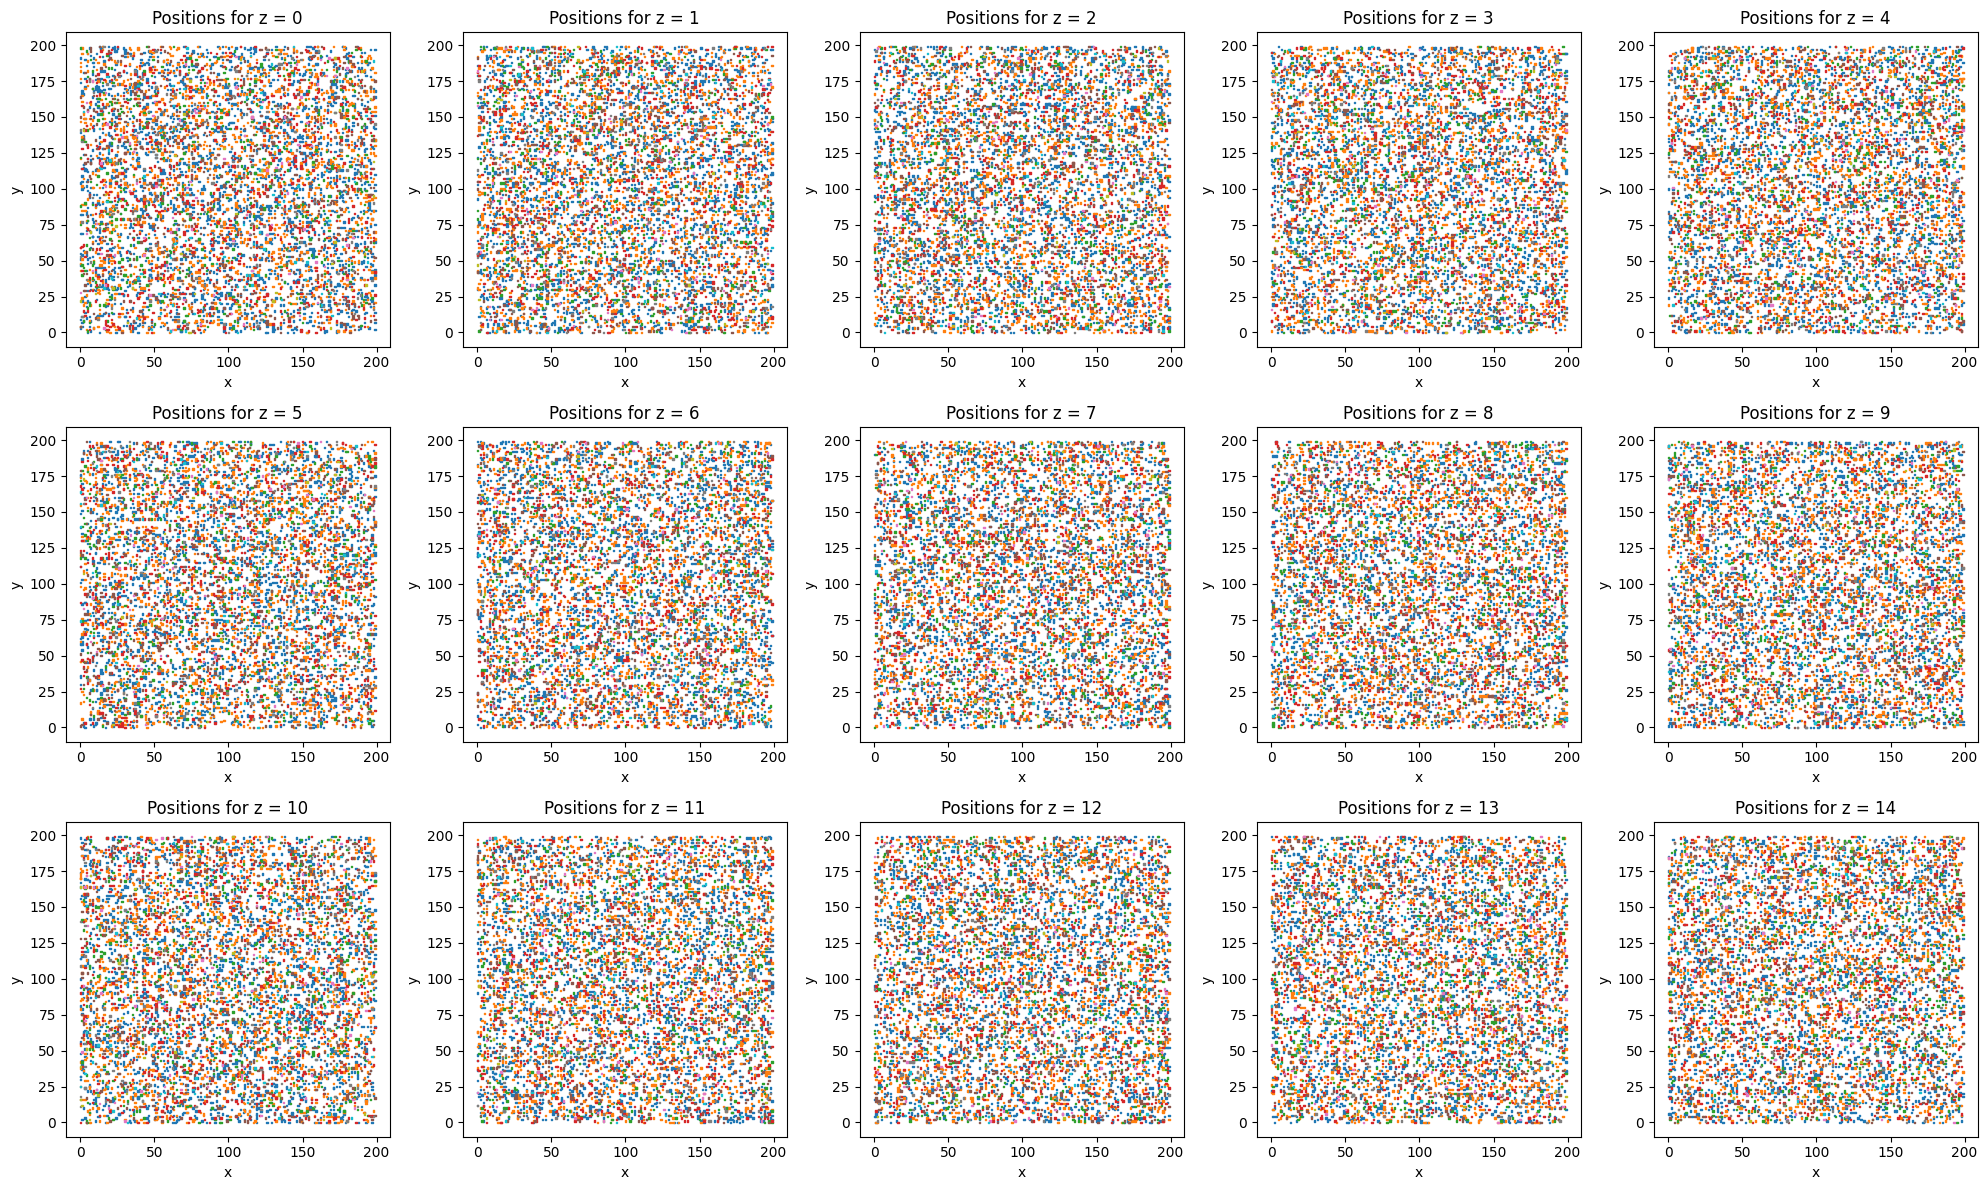

In [31]:
positions_old = np.load('init_pos.npy')

# Create a list of colors for each type
colors = plt.colormaps['tab10']

# Determine the type of each individual based on their index
types = []
start_index = np.zeros(num_types, dtype=int)
start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
for i in range(num_types):
    types.extend([i] * num_individuals_per_type[i])
types = np.array(types)

z_range = range(z_max)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, z in enumerate(z_range):
    ax = axes[i]
    mask = positions_old[:, 2] == z
    ax.scatter(positions_old[mask, 0], positions_old[mask, 1], c=types[mask], cmap=colors, s=1, marker='s')
    ax.set_title(f'Positions for z = {z}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.savefig("before.pdf", format="pdf", bbox_inches="tight")
plt.show()

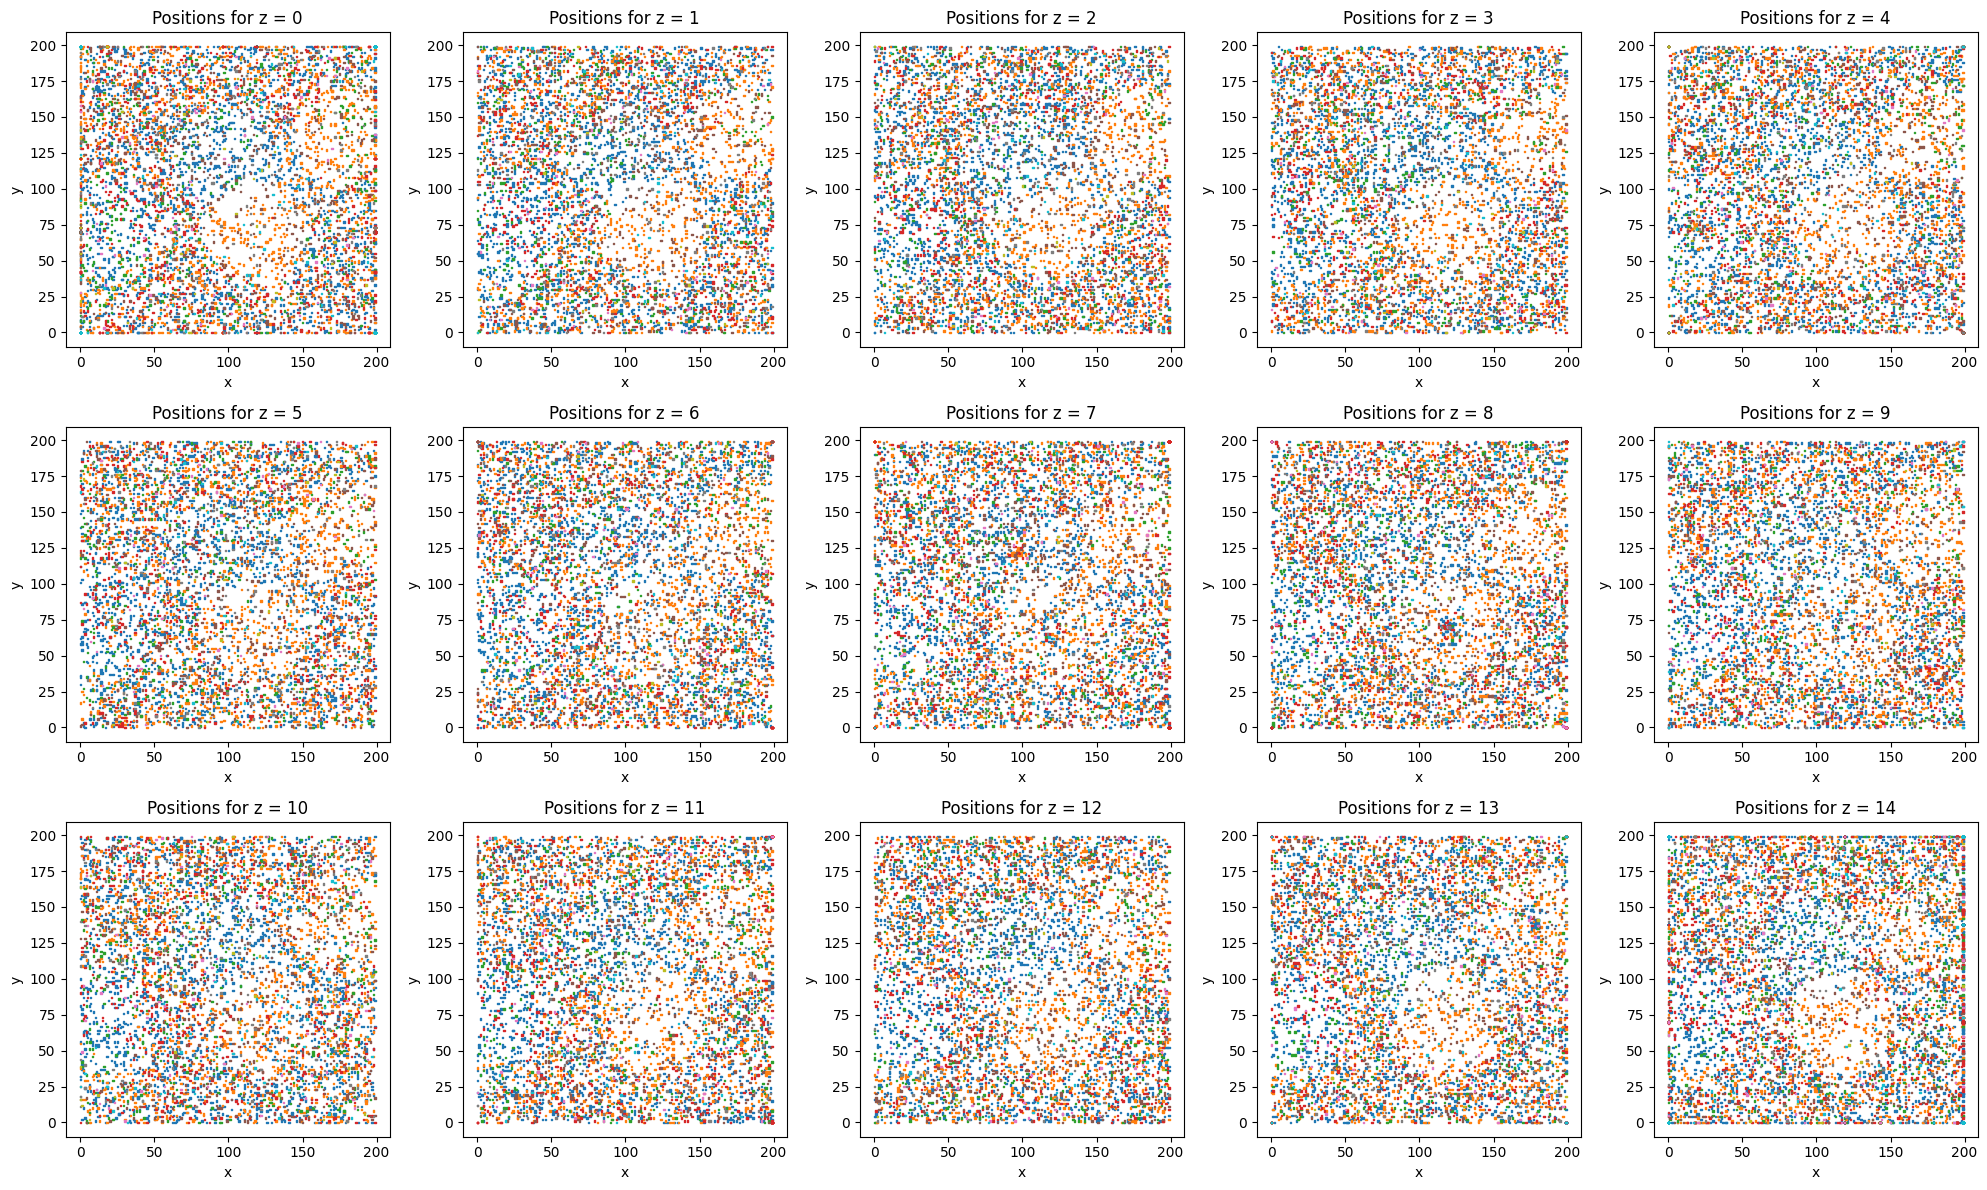

In [32]:
positions_new = np.load('resulting_pos.npy')
# Create a list of colors for each type
colors = plt.colormaps['tab10']

# Determine the type of each individual based on their index
types = []
start_index = np.zeros(num_types, dtype=int)
start_index[1:] = np.cumsum(num_individuals_per_type[:-1])
for i in range(num_types):
    types.extend([i] * num_individuals_per_type[i])
types = np.array(types)

z_range = range(z_max)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, z in enumerate(z_range):
    ax = axes[i]
    mask = positions_new[:, 2] == z
    ax.scatter(positions_new[mask, 0], positions_new[mask, 1], c=types[mask], cmap=colors, s=1, marker='s')
    ax.set_title(f'Positions for z = {z}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.savefig("after.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [33]:
# Function to count the number of changed positions
def count_changed_positions(initial_positions, final_positions):
    # Ensure both arrays are of the same shape
    assert initial_positions.shape == final_positions.shape, "Initial and final positions must have the same shape."
    
    # Count the number of positions that have changed
    changed_positions = np.sum(np.any(initial_positions != final_positions, axis=1))
    return changed_positions

# Count the number of changed positions
num_changed_positions = count_changed_positions(positions_old, positions_new)
print(f"Number of changed positions: {num_changed_positions}")

Number of changed positions: 20671


In [53]:
import numpy as np
from collections import defaultdict
from itertools import combinations

def get_von_neumann_neighbors(position, radius, x_max, y_max, z_max):
    neighbors = []
    x, y, z = position
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            for dz in range(-radius, radius + 1):
                if abs(dx) + abs(dy) + abs(dz) <= radius:
                    nx, ny, nz = x + dx, y + dy, z + dz
                    if 0 <= nx < x_max and 0 <= ny < y_max and 0 <= nz < z_max:
                        neighbors.append((nx, ny, nz))
    return neighbors

def calculate_dissimilarity_index(positions, types, num_individuals_per_type, radius, x_max, y_max, z_max):
    """
    Calculate the dissimilarity index D for each pair of types based on the von Neumann neighborhood.

    Parameters:
    - positions: A numpy array of shape (N, 3) representing the 3D coordinates of all individuals.
    - types: A numpy array of shape (N,) representing the type of each individual.
    - num_individuals_per_type: A list of integers indicating the number of individuals of each type.
    - radius: The radius of the von Neumann neighborhood.
    - x_max, y_max, z_max: Dimensions of the 3D space.

    Returns:
    - dissimilarity_indices: A dictionary where keys are tuples of type pairs and values are the calculated dissimilarity indices.
    """
    num_types = len(num_individuals_per_type)
    
    # Create a dictionary to map positions to indices
    pos_dict = {tuple(pos): idx for idx, pos in enumerate(positions)}
    
    # Initialize a dictionary to store the D values for each pair of types
    dissimilarity_indices = {(i, j): 0.0 for i, j in combinations(range(num_types), 2)}
    
    # Iterate over the 3D grid
    for x in range(x_max):
        for y in range(y_max):
            for z in range(z_max):
                pos = (x, y, z)
                neighbors = get_von_neumann_neighbors(pos, radius, x_max, y_max, z_max)
                
                # Count the number of each type in the neighborhood
                type_counts = {t: 0 for t in range(num_types)}
                for neighbor in neighbors:
                    if neighbor in pos_dict:
                        type_counts[types[pos_dict[neighbor]]] += 1
                
                # Calculate dissimilarity index for each pair (type_a, type_b)
                for type_a, type_b in combinations(range(num_types), 2):
                    proportion_a = type_counts[type_a] / num_individuals_per_type[type_a]
                    proportion_b = type_counts[type_b] / num_individuals_per_type[type_b]
                    dissimilarity_indices[(type_a, type_b)] += abs(proportion_a - proportion_b)

    # Normalize by the number of neighborhoods and divide by 2
    total_neighborhoods = x_max * y_max * z_max
    for key in dissimilarity_indices:
        dissimilarity_indices[key] /= (total_neighborhoods)

    return dissimilarity_indices

radius = 2  # Radius of the von Neumann neighborhood
dissimilarity_indices = calculate_dissimilarity_index(positions_new, types, num_individuals_per_type, radius, x_max, y_max, z_max)


In [54]:
import networkx as nx

def create_dissimilarity_graph(dissimilarity_indices):
    """
    Create an undirected weighted NetworkX graph from dissimilarity indices.

    Parameters:
    - dissimilarity_indices: A dictionary where keys are tuples of type pairs and values are the calculated dissimilarity indices.

    Returns:
    - G: A NetworkX graph with types as nodes and dissimilarity indices as edge weights.
    """
    G = nx.Graph()
    
    for (type_a, type_b), dissimilarity_index in dissimilarity_indices.items():
        G.add_edge(type_a, type_b, weight=dissimilarity_index)
    
    return G

# Example usage
G = create_dissimilarity_graph(dissimilarity_indices)

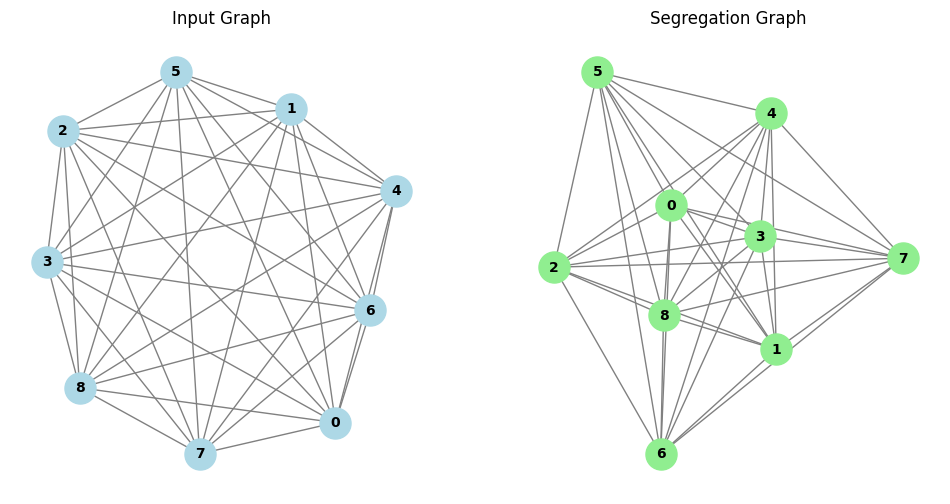

In [55]:
# Function to calculate von Neumann neighbors
def get_von_neumann_neighbors(pos, x_max, y_max, z_max):
    neighbors = []
    x, y, z = pos
    if x > 0: neighbors.append((x-1, y, z))
    if x < x_max - 1: neighbors.append((x+1, y, z))
    if y > 0: neighbors.append((x, y-1, z))
    if y < y_max - 1: neighbors.append((x, y+1, z))
    if z > 0: neighbors.append((x, y, z-1))
    if z < z_max - 1: neighbors.append((x, y, z+1))
    return neighbors

# Make this symmetrical, this is for a directed graph
# Function to calculate the segregation coefficient
def calculate_segregation_coefficient(positions, types, x_max, y_max, z_max):
    total_segregation = 0
    total_individuals = positions.shape[0]
    
    # Create a dictionary to map positions to types 
    pos_to_type = {tuple(pos): t for pos, t in zip(positions, types)}
    
    # Store local segregation values
    local_segregation = np.zeros(total_individuals)
    
    for index, (pos, type_i) in enumerate(zip(positions, types)):
        pos = tuple(pos)
        neighbors = get_von_neumann_neighbors(pos, x_max, y_max, z_max)
        same_type_count = sum(1 for n in neighbors if pos_to_type.get(n) == type_i)
        local_segregation[index] = same_type_count / len(neighbors)
        total_segregation += local_segregation[index]
    
    segregation_coefficient = total_segregation / total_individuals
    return segregation_coefficient, local_segregation

# Calculate the segregation coefficient and local segregations
segregation_coefficient, local_segregation = calculate_segregation_coefficient(positions_new, types, x_max, y_max, z_max)

# Create a segregation graph based on local segregation
G_segregation = nx.Graph()
for type_id in range(num_types):
    G_segregation.add_node(type_id)

# Calculate average segregation between types
for i in range(num_types):
    for j in range(i + 1, num_types):
        indices_i = np.where(types == i)[0]
        indices_j = np.where(types == j)[0]
        local_segregation_i = local_segregation[indices_i]
        local_segregation_j = local_segregation[indices_j]
        
        avg_segregation_i = np.mean(local_segregation_i)
        avg_segregation_j = np.mean(local_segregation_j)
        
        avg_segregation = (avg_segregation_i + avg_segregation_j) / 2
        
        G_segregation.add_edge(i, j, weight=avg_segregation)

# Plotting the graphs for visual comparison
plt.figure(figsize=(12, 6))

plt.subplot(121)
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, font_weight='bold')
plt.title('Input Graph')

plt.subplot(122)
nx.draw(G_segregation, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500, font_size=10, font_weight='bold')
plt.title('Segregation Graph')

plt.show()

In [56]:
from scipy.stats import pearsonr

# Function to get edge weights from a graph as a list
def get_edge_weights(graph):
    return [graph[u][v]['weight'] for u, v in graph.edges]

# Get edge weights from both graphs
input_weights = get_edge_weights(G)
segregation_weights = get_edge_weights(G_segregation)

# Ensure both graphs have the same edges
assert set(G.edges) == set(G_segregation.edges), "Graphs have different edges."

# Calculate Pearson correlation coefficient
correlation, p_val = pearsonr(input_weights, segregation_weights)

print(f"Pearson correlation coefficient between the input graph and segregation graph: {correlation:.4f} p: {p_val:.4f}")


Pearson correlation coefficient between the input graph and segregation graph: -0.6958 p: 0.0000
